<br>
<font color="#500000" size=15 style="margin:2cm"> AGGREGATIBACTER FUSE</font>



In [27]:
# importing modules
import matplotlib.pyplot as plt
import numpy as np
from skfusion import fusion
from cross_validation import *
import pickle
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0)

#Matrices import

Load in all the matrices!

In [28]:
prot_rna = pickle.load(open('../matrices/pickles/cr_z-score_raw.pkl', 'rb'))
secretion_prot = pickle.load(open('../matrices/pickles/signalP.pkl', 'rb'))
rna_expression = pickle.load(open('../matrices/pickles/MA_exp.pkl', 'rb'))


# Data transformation

In [29]:
# remove data for genes with no catrapid prediction
selection = prot_rna.any(axis=1)
prot_rna = prot_rna[selection,:]
secretion_prot = secretion_prot[:, selection]

# Addd pseudo rows 
# TODO: remove when fixed!
secretion_prot = np.vstack((secretion_prot, secretion_prot, secretion_prot, secretion_prot, secretion_prot))

rna_expression = rna_expression.reshape(rna_expression.shape[0],1)
rna_expression = np.hstack((rna_expression, rna_expression, rna_expression, rna_expression, rna_expression))


# Display shapes
print('secretion_prot:', secretion_prot.shape)
print('rna_expression:', rna_expression.shape)
print('prot_rna:', prot_rna.shape)

secretion_prot: (5, 2001)
rna_expression: (7097, 5)
prot_rna: (2001, 7097)


# Data fusion setup

In [30]:
# Define names
secretion = fusion.ObjectType('SignalP', 1)
prot = fusion.ObjectType('AAprot', 100)
genes = fusion.ObjectType('HSgenes', 200)
# TODO: lower when possible
expr = fusion.ObjectType('HSexpression', 2)

# Define relations
relations = [fusion.Relation(secretion_prot, secretion, prot),
                 fusion.Relation(prot_rna, prot, genes, name='catrapid'),
                 fusion.Relation(rna_expression, genes, expr)]



# Validation Functions

In [31]:
# Full build
def cross_validate(relations, cv_fold=5, th=2.5, random_state=1):
    """
    Performs cross valiation on give first matrix of relation and returns
    lists ouf AUC score and average deviation.
    """
    auc_vals = []
    avr_dev = []
    orig_matrix = relations[0].data
    for cv_matrix, elements in matrix_cv_setup(orig_matrix, n_fold=cv_fold, alternative=0):
        relations[0].data = cv_matrix
        reconst_mat = dfmf_n_reconstruct(relations, random_state=random_state)

        auc_vals.append(auc_value(orig_matrix, reconst_mat, elements, treshold=th))
        avr_dev.append(avr_res(orig_matrix, reconst_mat, elements))
    print('\tAUC value is:', np.mean(auc_vals))
    print('\tAverage deviation is:', np.mean(avr_dev))
    relations[0].data = orig_matrix

def dfmf_n_reconstruct(relationships, random_state=1):
    """
    Given relationships, reconstructs the matrix
    """
    fusion_graph = fusion.FusionGraph(relations)

    fuser = fusion.Dfmf(random_state=random_state)
    fuser.fuse(fusion_graph)
    return fuser.complete(fusion_graph['catrapid'])


# AUC threshold selection

We are calculating for top 0.6351% interactions


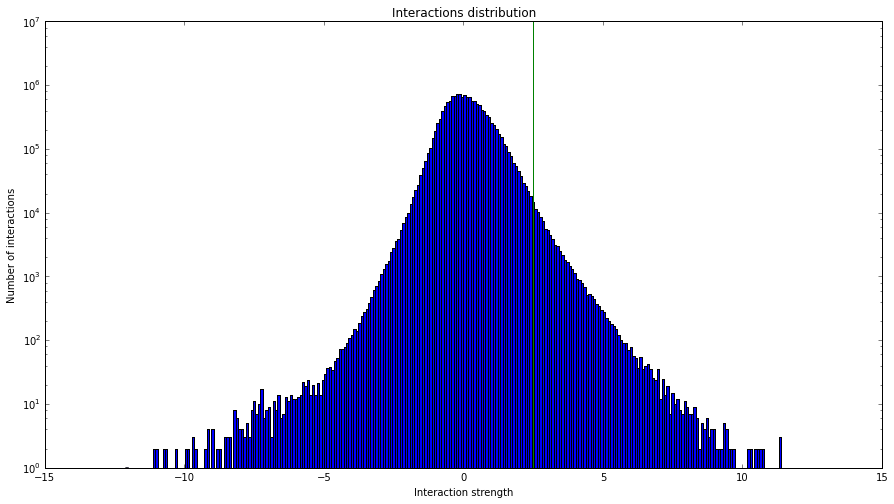

In [36]:
auc_th = 2.5
plt.hist(prot_rna.flatten(), bins= 300, log=True);
plt.plot((auc_th, auc_th), (0, 10**7));
plt.title("Interactions distribution");
plt.xlabel("Interaction strength");
plt.ylabel("Number of interactions");

print('We are calculating for top {:.4f}% interactions'.format(np.sum(prot_rna > auc_th) / prot_rna.size *100))

In [10]:
# TODO: nariši scikit-learn ROC - Curve

# grafično prikaži -> RNA pred vs. Realna

# grafično prikaži kateri so positive!

# kako dobro napovedujemo ekspresijo / sekrecijo

# ALI je v sci-kit fusion že metoda za evaluacijo informativnosti

# KAKO BI DOBILI  KANDIDATE! 

0.63507769857497631

# Predictions

In [7]:
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(secretion_prot, secretion, prot),
             fusion.Relation(rna_expression, genes, expr)]

print('Interactions, Secretion and Expression:')
cross_validate(relations, cv_fold=10, th=auc_th)
print()

Interactions, Secretion and Expression:
	AUC value is: 0.999139963359
	Average deviation is: 0.111351484814



In [8]:
print('with Secretion:')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(secretion_prot, secretion, prot)]

cross_validate(relations, cv_fold=10, th=auc_th)
print()

with Secretion:
	AUC value is: 0.999149572367
	Average deviation is: 0.111474792171



In [9]:
print('with Expression:')

relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
             fusion.Relation(rna_expression, genes, expr)]

relations.append(fusion.Relation(rna_expression, genes, expr))
cross_validate(relations, cv_fold=10, th=auc_th)
print()

with Expression:
	AUC value is: 0.999194992586
	Average deviation is: 0.111102511372



In [10]:
print('Only Interactions:')
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid')]
cross_validate(relations, cv_fold=10, th=auc_th)
print()

Only Interactions:
	AUC value is: 0.999209379987
	Average deviation is: 0.111127912499



<h2>Test on shuffled data</h2>

In [11]:
np.random.seed(100)

def shuffle_rows(my_array):
    """
    Returns array with rows shuffled
    """
    sh_idx = np.arange(my_array.shape[0])
    np.random.shuffle(sh_idx)
    return my_array[sh_idx,:]

def shuffle_cols(my_array):
    """
    Returns array with rows shuffled
    """
    sh_idx = np.arange(my_array.shape[1])
    np.random.shuffle(sh_idx)
    return my_array[:, sh_idx]



In [12]:
print('Expression shuffle test') 

for i in range(10):
    shuffled_expressions = shuffle_rows(rna_expression)  
    relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
                 fusion.Relation(shuffled_expressions, genes, expr)]

    relations.append(fusion.Relation(rna_expression, genes, expr))
    cross_validate(relations, cv_fold=10, th=auc_th)
    print()

Expression shuffle test
	AUC value is: 0.999195354178
	Average deviation is: 0.111190000088

	AUC value is: 0.999208408749
	Average deviation is: 0.111139111161

	AUC value is: 0.999206709903
	Average deviation is: 0.111051958007

	AUC value is: 0.99922023423
	Average deviation is: 0.11105588826

	AUC value is: 0.999176437265
	Average deviation is: 0.111037655048

	AUC value is: 0.999189248109
	Average deviation is: 0.1111605748

	AUC value is: 0.99917680213
	Average deviation is: 0.111167208098

	AUC value is: 0.999211880655
	Average deviation is: 0.111169957547

	AUC value is: 0.999207092767
	Average deviation is: 0.111161600804

	AUC value is: 0.999188094817
	Average deviation is: 0.11115207385



In [13]:
print('Secretion shuffle test') 

for i in range(10):
    shuffled_secretions = shuffle_cols(secretion_prot)  
    relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid'),
                 fusion.Relation(secretion_prot, secretion, prot)]

    cross_validate(relations, cv_fold=10, th=auc_th)
    print()

Secretion shuffle test
	AUC value is: 0.99913207201
	Average deviation is: 0.111426878168

	AUC value is: 0.999151006445
	Average deviation is: 0.111343029459

	AUC value is: 0.999176741448
	Average deviation is: 0.111311577242

	AUC value is: 0.999143856786
	Average deviation is: 0.111346510493

	AUC value is: 0.999131853299
	Average deviation is: 0.111398761867

	AUC value is: 0.99916148794
	Average deviation is: 0.111469121235

	AUC value is: 0.999120393672
	Average deviation is: 0.111496385736

	AUC value is: 0.999138375587
	Average deviation is: 0.111418401334

	AUC value is: 0.999149343174
	Average deviation is: 0.111411891082

	AUC value is: 0.999163575871
	Average deviation is: 0.111355724249



<h2>Inicialization Test</h2>

In [ ]:
relations = [fusion.Relation(prot_rna, prot, genes, name='catrapid')]


for i in range(50):
    cross_validate(relations, cv_fold=10, th=0, random_state=i)


	AUC value is: 0.993246549902
	Average deviation is: 0.11124499709
	AUC value is: 0.993237802387
	Average deviation is: 0.111152769404
	AUC value is: 0.993245079547
	Average deviation is: 0.111196877663
	AUC value is: